In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Tensors and operations
### Tensors


In [2]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [3]:
tf.constant(42) # scalar


<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

## Using keras.backend


In [5]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

## Variables
mutable, other immutable

In [6]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])


In [7]:
v.assign(2 * v)


<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [8]:
v[0, 1].assign(42)


<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [9]:
v[:, 2].assign([0., 1.])


<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

## Custom loss function


In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [62]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    print(tf.where(is_small_error, squared_loss, linear_loss))
    return tf.where(is_small_error, squared_loss, linear_loss) ## 1: check condition, 2: true, 3:false

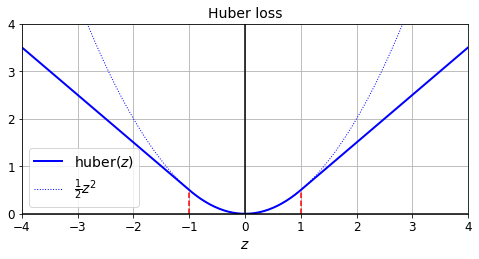

In [12]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [13]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [14]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])


In [15]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.6235 - mae: 0.9953 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2197 - mae: 0.5177 - val_loss: 0.2382 - val_mae: 0.5281


## Saving/Loading Models with Custom Objects


In [16]:
model.save("my_model_with_a_custom_loss.h5")

In [17]:

model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [18]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


In [19]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [20]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])


In [21]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.2226 - mae: 0.4892 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2184 - mae: 0.4844 - val_loss: 0.2372 - val_mae: 0.4879


In [22]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")


In [23]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [24]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


### *** super custom

In [25]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [26]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [27]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])


In [28]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 4ms/step - loss: 0.7095 - mae: 0.8863 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2416 - mae: 0.5083 - val_loss: 0.2660 - val_mae: 0.5089


In [29]:
model.save("my_model_with_a_custom_loss_class.h5")


In [30]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [31]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [32]:
model.loss.threshold


2.0

## Other Custom Functions

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)


In [34]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [35]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [37]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])


In [38]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [39]:
model.save("my_model_with_many_custom_parts.h5")


In [40]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Custom Metrics


In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [43]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 2.0982 - huber_fn: 0.9192
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.6052 - huber_fn: 0.2733


Note: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:

+ the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
+ the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).



In [44]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])


In [46]:

sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 3s 3ms/step - loss: 0.1175 - huber_fn: 0.2399
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.1131 - huber_fn: 0.2297


In [47]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()


(0.11749906837940216, 0.11906625573138947)

## Streaming metrics


In [48]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [49]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])


<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [50]:
precision.result()


<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [51]:
precision.variables


[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [52]:
precision.reset_states()


In [63]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [64]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [65]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [66]:
m.variables


[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [67]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [68]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.2595 - huber_metric: 0.2595


In [70]:
model.save("my_model_with_a_custom_metric.h5")
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [71]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2278 - huber_metric: 0.2278


In [72]:
model.metrics[-1].threshold


2.0

### simply

In [73]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}   

In [74]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [75]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 4s 4ms/step - loss: 0.4455 - HuberMetric: 0.8978
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1305 - HuberMetric: 0.2631


In [76]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()


(0.44554394483566284, 0.44554404180100277)

In [77]:
model.save("my_model_with_a_custom_metric_v2.h5")


In [78]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 4ms/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 1s 4ms/step - loss: 0.2279 - HuberMetric: 0.2279


In [79]:
model.metrics[-1].threshold


2.0

## Custom Layers


In [80]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 2ms/step - loss: 0.3586


0.3586341142654419

In [82]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}


In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 5s 7ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 2ms/step - loss: 0.5474


0.5473727583885193

In [84]:
model.save("my_model_with_a_custom_layer.h5")


In [85]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [86]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [87]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [88]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [89]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))


X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [91]:
model.compile(loss='mse', optimizer='nadam')
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))


Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 3s 5ms/step - loss: 2.1142 - val_loss: 1.3630
Epoch 2/2
363/363 [==============================] - 2s 4ms/step - loss: 0.9684 - val_loss: 0.9773


In [92]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [94]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)


Epoch 1/2
363/363 [==============================] - 3s 5ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 3ms/step - loss: 0.7560


0.7559615969657898

## Custom Models


In [95]:
X_new_scaled = X_test_scaled
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [96]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)


Epoch 1/5
363/363 [==============================] - 5s 5ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 2s 7ms/step - loss: 1.0578
Epoch 3/5
363/363 [==============================] - 3s 8ms/step - loss: 0.8868
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5833
Epoch 5/5
162/162 [==============================] - 1s 3ms/step - loss: 0.6505


In [97]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [98]:
model = keras.models.load_model("my_custom_model.ckpt")
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 5s 5ms/step - loss: 0.8020
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5451
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4602
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5316
Epoch 5/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4782


In [99]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [100]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)


Epoch 1/5
363/363 [==============================] - 5s 4ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: 0.3809
Epoch 5/5
162/162 [==============================] - 1s 3ms/step - loss: 0.4852


## Losses and Metrics Based on Model Internals
Note: the following code has two differences with the code in the book:

+ It creates a keras.metrics.Mean() metric in the constructor and uses it in the call() method to track the mean reconstruction loss. Since we only want to do this during training, we add a training argument to the call() method, and if training is True, then we update reconstruction_mean and we call self.add_metric() to ensure it's displayed properly.
+ Due to an issue introduced in TF 2.2 (#46858), we must not call super().build() inside the build() method.

In [101]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)


Epoch 1/2
363/363 [==============================] - 6s 5ms/step - loss: 0.7885 - reconstruction_error: 1.0474
Epoch 2/2
363/363 [==============================] - 2s 5ms/step - loss: 0.4126 - reconstruction_error: 0.4022


## Computing Gradients with Autodiff


In [103]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [104]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps


36.000003007075065

In [105]:
(f(w1, w2 + eps) - f(w1, w2)) / eps


10.000000003174137

In [106]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])


In [107]:
gradients


[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [108]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [109]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [110]:
dz_dw1, dz_dw2


(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [111]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [112]:
gradients


[None, None]

In [113]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [114]:
gradients


[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [115]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])


[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [116]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [117]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [118]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [119]:
hessians


[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [120]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [121]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [122]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)


<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [123]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])


[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [124]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [125]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [126]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Computing Gradients Using Autodiff


In [127]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [128]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [129]:
progress_bar(3500, 10000, size=6)


' 3500/10000 [=>....]'

In [130]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [131]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()


Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [132]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## TensorFlow Functions


In [133]:

def cube(x):
    return x ** 3
cube(2)

8

In [134]:
cube(tf.constant(2.0))


<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [135]:
tf_cube = tf.function(cube)
tf_cube

In [136]:
tf_cube(tf.constant(2.0))


<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

## TF Functions and Concrete Functions


In [137]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [138]:
concrete_function(tf.constant(2.0))


<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [139]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))


True

## Exercises
### Q12

In [141]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

In [142]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=5.496049e-08>

In [143]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=2.3469148e-08>

### 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset

In [144]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

4431872/4422102 [==============================] - 0s 0us/step


In [145]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [146]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

In [147]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [148]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [149]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]